# 1. Imposing the Swing States

In [ ]:
import praw
import pandas as pd
from datetime import datetime

# 🔑 Reddit API credentials

reddit = praw.Reddit(
    client_id="FkAtvLpgd1gvtbsgvz9X-g",
    client_secret="jD-UABZX6Fkp6kIcsPDa42roIQdgyg",
    user_agent="swing_state_scraper"
)

# 🔁 Collect posts & comments from swing state subreddits
def fetch_reddit_posts_and_comments(subreddit_name, limit=50):
    subreddit = reddit.subreddit(subreddit_name)
    data = []

    for submission in subreddit.top(limit=limit):
        if not submission.stickied:
            post = {
                'title': submission.title,
                'text': submission.selftext,
                'created_utc': datetime.utcfromtimestamp(submission.created_utc),
                'subreddit': subreddit_name,
                'comments': []
            }
            submission.comments.replace_more(limit=0)
            post['comments'] = [comment.body for comment in submission.comments[:10]]
            data.append(post)

    return pd.DataFrame(data)


# 🔁 Loop through swing states
swing_state_subs = ['Pennsylvania', 'Georgia', 'Michigan', 'Wisconsin', 'Arizona', 'NorthCarolina', 'Nevada']

all_dfs = []

for state in swing_state_subs:
    try:
        df_state = fetch_reddit_posts_and_comments(state, limit=50)
        df_state['state'] = state
        all_dfs.append(df_state)
    except Exception as e:
        print(f"Error fetching from r/{state}: {e}")

df = pd.concat(all_dfs, ignore_index=True)




Version 7.7.1 of praw is outdated. Version 7.8.1 was released Friday October 25, 2024.


 # 2. Clean and Proccess Text

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")

def clean(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|[^a-zA-Z ]", "", text.lower())
    tokens = text.split()
    tokens = [WordNetLemmatizer().lemmatize(w) for w in tokens if w not in stopwords.words("english")]
    return " ".join(tokens)

# Make sure full_text exists
df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

# Create cleaned_text column
df['cleaned_text'] = df['full_text'].apply(clean)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maktr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maktr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 3. Sentiment Analysis with VADER

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")

# Fix missing 'full_text'
df['full_text'] = df['title'].fillna('') + " " + df['text'].fillna('')

# Run sentiment analysis
sia = SentimentIntensityAnalyzer()
df['post_sentiment'] = df['full_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Average top 10 comment sentiment
df['comment_sentiment'] = df['comments'].apply(
    lambda comments: sum(sia.polarity_scores(c)['compound'] for c in comments) / len(comments) if comments else 0
)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\maktr\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 4. Topic Modeling (Discovering Voter Issues)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.95, min_df=10, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_text'])

lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(X)

words = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"Topic {i}: ", [words[i] for i in topic.argsort()[-50:]])


Topic 0:  ['kamala', 'day', 'georgia', 'voter', 'wisconsin', 'rally', 'harris', 'election', 'michigan', 'pennsylvania', 'lead', 'democrat', 'think', 'know', 'senator', 'vote', 'like', 'need', 'time', 'voting', 'trump', 'make', 'state', 'year', 'today', 'dont', 'republican', 'people', 'public', 'want', 'right', 'arizona', 'nevada']
Topic 1:  ['democrat', 'need', 'senator', 'nevada', 'dont', 'voting', 'right', 'today', 'time', 'year', 'think', 'arizona', 'georgia', 'people', 'state', 'michigan', 'day', 'rally', 'like', 'election', 'pennsylvania', 'make', 'vote', 'know', 'want', 'public', 'voter', 'wisconsin', 'trump', 'republican', 'lead', 'kamala', 'harris']
Topic 2:  ['rally', 'day', 'time', 'republican', 'arizona', 'nevada', 'harris', 'michigan', 'kamala', 'election', 'wisconsin', 'year', 'today', 'state', 'trump', 'like', 'right', 'people', 'senator', 'georgia', 'public', 'know', 'want', 'make', 'dont', 'voting', 'think', 'vote', 'lead', 'voter', 'pennsylvania', 'need', 'democrat']
T

# 5. Filter by Policy Issue (Optional Keyword Masking)

In [ ]:
# Economy-related topics
df['economy'] = df['cleaned_text'].str.contains(
    r"(economy|inflation|ai|transportation|artifical intelligence|expensive|price|prices|automation|oligarchy|tax|taxes|billionaires|infrastructure|corruption|bigmoney|road|roads|rich|monopoly|monopolies|welfare|debt|deficit|war|wars|corporate|china|manufacturing|tariff|tariffs|trade|freetrade|protection|protectionism|corporation|corporations|union|laborunion|raise|poor|homeless|homelessness|regulation|regulations|injob|jobs|employment|unemployment|cost|housing|rent|mortgage|utilities|money|income|wages|salary|stock|market|gas|groceries|price|bills|budget|recession)",
    case=False
)

# Immigration-related topics
df['immigration'] = df['cleaned_text'].str.contains(
    r"(immigration|border|asylum|illegal|immigrant|immigrants|migrant|migrants|deport|citizenship|visa|ICE|CBP|detain|wall|refugee|DACA)",
    case=False
)

# Healthcare-related topics
df['healthcare'] = df['cleaned_text'].str.contains(
    r"(healthcare|health|insurance|medicare|medicaid|obamacare|doctor|hospital|nurse|mental|medical|dental|drug|prescription|copay|abortion|coverage|premium|clinic|healthcarecost|ER)",
    case=False
)

# Education-related topics
df['education'] = df['cleaned_text'].str.contains(
    r"(education|school|schools|teacher|teachers|crt|woke|student|students|university|college|curriculum|classroom|learning|publicschool|charterschool|homeschool|schoolboard|debt|loan|tuition|academic|SAT|ACT|funding|literacy|GED)",
    case=False
)

# Environment-related topics
df['environment'] = df['cleaned_text'].str.contains(
    r"(environment|climate change|global warming|pollution|emissions|carbon|greenhouse|energy|renewable|solar|coal|gas|mining|wind|recycling|plastic|wildfire|flood|drought|EPA|deforestation|sustainability|cleanenergy|biodiversity)",
    case=False
)

# Human rights–related topics
df['human_rights'] = df['cleaned_text'].str.contains(
    r"(human rights|civil rights|dei|police|shooting|gun|guns|first amendment|shooting|shootings|hate|xenephobia|xenephobic|freedom|freedoms|freepalestine|palestine|anti-semetic|anti-semitism|gaza|woke|equalrights|equality|inequality|discrimination|racism|lgbt|trans|transgender|gay|lesbian|marriageequality|policebrutality|justice|injustice|prison|incarceration|protest|activism|rights|speech|press|votingrights|womensrights|reproductive|abortion|bodilyautonomy|religiousfreedom|minority|oppression)",
    case=False
)

# Politics
df['politics'] = df['cleaned_text'].str.contains(
    r"(democracy|right to vote|law|corrupt|politican|donor|donors|special interests|billionaires|supremecourt|court|politicans|democrats|republican|republicans|gop|corruption|populism|populist|statusquo|elite|elitism|old|musk|young|libs|lib|conservative|conservatives|dnc|rnc|2020|voter fraud)",
    case=False
)



def label_issue(row):
    if row['economy']:
        return 'Economy'
    elif row['immigration']:
        return 'Immigration'
    elif row['healthcare']:
        return 'Healthcare'
    elif row['education']:
        return 'Education'
    elif row['environment']:
        return 'Environment'
    elif row['human_rights']:
        return 'Human Rights'
    elif row['politics']:
        return 'Politics'
    

df['top_issue'] = df.apply(label_issue, axis=1)





C:\Users\maktr\AppData\Local\Temp\ipykernel_17824\277186538.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['economy'] = df['cleaned_text'].str.contains(
C:\Users\maktr\AppData\Local\Temp\ipykernel_17824\277186538.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['immigration'] = df['cleaned_text'].str.contains(
C:\Users\maktr\AppData\Local\Temp\ipykernel_17824\277186538.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['healthcare'] = df['cleaned_text'].str.contains(
C:\Users\maktr\AppData\Local\Temp\ipykernel_17824\277186538.py:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['education'] = df['cleaned_text'].str

# 7. Aggregate by State and Topic

In [ ]:
# Monthly sentiment
df['month'] = df['created_utc'].dt.to_period('M')
monthly_sentiment = df.groupby(['month', 'state'])['post_sentiment'].mean().unstack()

# Average sentiment by issue
for topic in ['economy', 'immigration', 'healthcare', 'education', 'environment', 'human_rights', 'politics']:
    avg = df[df[topic]]['post_sentiment'].mean()
    print(f"{topic.title()} Sentiment Avg: {avg:.2f}")

Economy Sentiment Avg: -0.02
Immigration Sentiment Avg: -0.07
Healthcare Sentiment Avg: -0.04
Education Sentiment Avg: -0.02
Environment Sentiment Avg: -0.11
Human_Rights Sentiment Avg: -0.04
Politics Sentiment Avg: -0.01


# 8. Visual

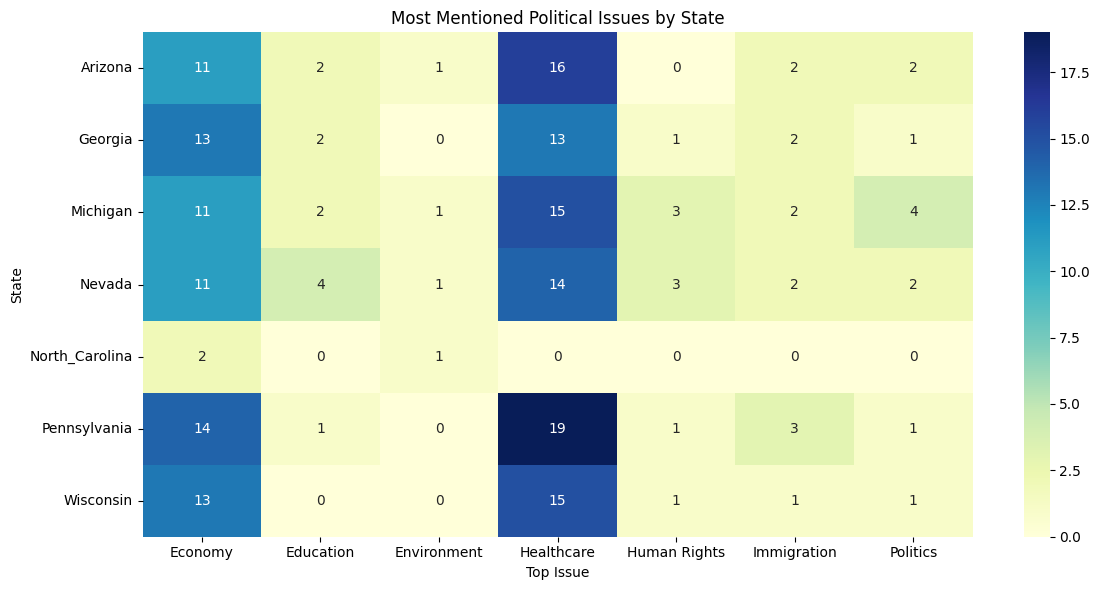

In [ ]:
issue_counts = df.groupby(['state', 'top_issue']).size().reset_index(name='count')
issue_pivot = issue_counts.pivot(index='state', columns='top_issue', values='count').fillna(0).astype(int)
issue_pivot = issue_pivot.sort_index()


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(issue_pivot, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Most Mentioned Political Issues by State")
plt.ylabel("State")
plt.xlabel("Top Issue")
plt.tight_layout()
plt.show()


# Word Cloud per State

## 1. Import and setup

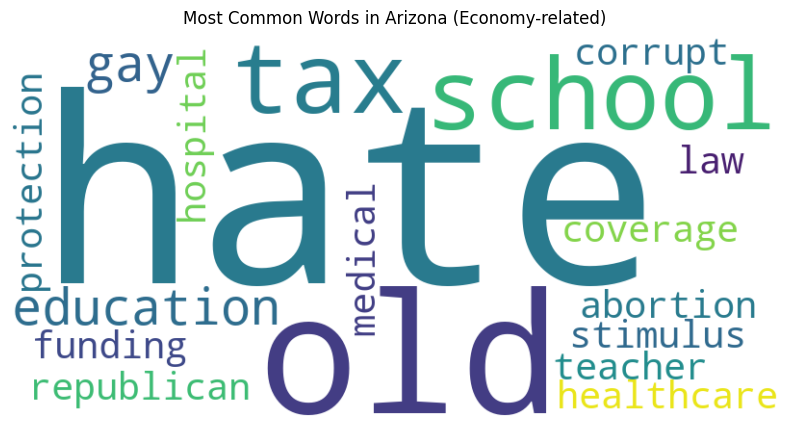

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

def plot_topic_wordcloud(state_name, keywords, df):
    # Join all posts for that state
    state_text = " ".join(df[df['state'] == state_name]['cleaned_text'].dropna())
    
    # Tokenize and filter for keywords only
    token_list = state_text.split()
    filtered_words = [word for word in token_list if word.lower() in keywords]
    filtered_text = " ".join(filtered_words)

    # Create and show word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(filtered_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Most Common Words in {state_name} (Economy-related)")
    plt.show()

# Example for Arizona + economy
plot_topic_wordcloud("Arizona", keywords, df)
